In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras


In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"
train_data = pd.read_csv(TRAIN_DATA_URL)
test_data = pd.read_csv(TEST_DATA_URL)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
train_data.describe()

In [ ]:
train_data.age.hist(bins =20)
plt.show()

In [ ]:
train_data.sex.value_counts().plot(kind = 'barh')
plt.show()

In [ ]:
train_data['class'].value_counts().plot(kind = 'barh')
plt.show()

In [ ]:
train_data.groupby('sex').survived.mean().plot(kind='bar')

In [ ]:
train_data.groupby('class').survived.mean().plot(kind='bar')

In [ ]:
train_data.groupby('alone').survived.mean().plot(kind='bar')

In [ ]:
train_data.groupby('deck').survived.mean().plot(kind='bar')

In [ ]:
train_data[train_data.isnull()].count()

In [3]:
y_train= train_data.pop('survived')
y_test = test_data.pop('survived')


In [ ]:
train_data.head()

In [4]:
categorocal_columns =['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numeric_columns=['age','fare']
feature_columns = []
#处理离散值特征
for categorocal_column in categorocal_columns:
    vocab = train_data[categorocal_column].unique()
    print(categorocal_column,': ',vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
                    tf.feature_column.categorical_column_with_vocabulary_list(
                                                                              categorocal_column, vocab)))
# tf.feature_column.indicator_column,对离散数据进行one_hot编码

#处理连续型特征
for numeric_column in numeric_columns:
    feature_columns.append(
          tf.feature_column.numeric_column(
                      numeric_column, dtype=tf.float32))

sex :  ['male' 'female']
n_siblings_spouses :  [1 0 3 4 2 5 8]
parch :  [0 1 2 5 3 4]
class :  ['Third' 'First' 'Second']
deck :  ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town :  ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone :  ['n' 'y']


In [ ]:
feature_columns[1]

In [5]:
#构建datasets
def make_dataset(x,y,epochs=10,shuffle=True,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(x), y))#from_tensor_slices要传入字典
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset
    

In [6]:
train_dataset = make_dataset(train_data, y_train,batch_size=30)

In [12]:
for x,y in train_dataset.take(1):
    print(x, '\n\n', y, '\n\n',x['age'])


{'sex': <tf.Tensor: id=7142, shape=(32,), dtype=string, numpy=
array([b'female', b'male', b'male', b'female', b'female', b'male',
       b'female', b'female', b'male', b'female', b'male', b'female',
       b'female', b'male', b'male', b'male', b'male', b'male', b'male',
       b'male', b'male', b'male', b'female', b'female', b'male',
       b'female', b'male', b'male', b'male', b'male', b'female', b'male'],
      dtype=object)>, 'age': <tf.Tensor: id=7134, shape=(32,), dtype=float64, numpy=
array([50. , 28. , 28. , 22. , 54. , 36. , 23. , 34. , 19. , 28. , 59. ,
       23. , 27. , 29. , 19. , 28. , 36. , 28. , 20. , 31. , 71. , 37. ,
       30. , 28. , 26. , 31. , 32.5, 32. , 21. , 32. , 28. , 34. ])>, 'n_siblings_spouses': <tf.Tensor: id=7140, shape=(32,), dtype=int32, numpy=
array([0, 8, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 8, 0, 0, 0, 1,
       0, 8, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int32)>, 'parch': <tf.Tensor: id=7141, shape=(32,), dtype=int32, numpy=
array([0, 2, 0, 2, 0, 0

In [7]:
#实验
# keras.layers.DenseFeatures可以将Feature定义的规则运用到dataset的每一个数据上

for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())#将age_column的规则运用到x上在打印numpy值
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())
#出现warning是提示float64自动转为float32，tensorflow2可以忽略


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[42.]
 [28.]
 [33.]
 [31.]
 [28.]
 [26.]
 [28.]
 [28.]
 [29.]
 [17.]
 [25.]
 [80.]
 [36.]
 [28.]
 [28.]
 [47.]
 [28.]
 [31.]
 [18.]
 [28.]
 [31.]
 [30.]
 [31.]
 [28.]
 [28.]
 [11.]
 [28.]
 [50.]
 [14.]
 [28.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To

In [ ]:
#实验
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())#将feature_columns的规则运用到x上在打印numpy值


In [8]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
                     optimizer = keras.optimizers.SGD(lr=0.01),
                     metrics = ['accuracy'])



In [10]:
# 1.model.fit
# 2.model -> estimator ->train
train_dataset = make_dataset(train_data, y_train,epochs=100)
test_dataset = make_dataset(test_data, y_test,epochs=1,shuffle=False)
history = model.fit(train_dataset,steps_per_epoch=18,epochs=100)#steps_per_epoch=训练集的样本数//batch_size


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 18 steps
Epoch 1/100
18/18 [==============================] - 3s 145ms/step - loss: 1.6090 - accuracy: 0.6285
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 0.7331 - accuracy: 0.6493
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 0.6509 - accuracy: 0.6858
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6303 - accuracy: 0.6701
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6811 - accur

Epoch 75/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5458 - accuracy: 0.7431
Epoch 76/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5050 - accuracy: 0.7465
Epoch 77/100
18/18 [==============================] - 0s 10ms/step - loss: 0.5266 - accuracy: 0.7552
Epoch 78/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5502 - accuracy: 0.7309
Epoch 79/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5444 - accuracy: 0.7431
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5258 - accuracy: 0.7517
Epoch 81/100
18/18 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.7170
Epoch 82/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5117 - accuracy: 0.7569
Epoch 83/100
18/18 [==============================] - 0s 11ms/step - loss: 0.5105 - accuracy: 0.7535
Epoch 84/100
18/18 [==============================] - 0s 12ms/step - loss: 0.5245 - accurac

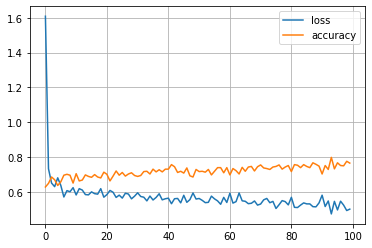

In [11]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [ ]:
# 2.model -> estimator ->train
estimator = keras.estimator.model_to_estimator(model)
estimator.train(input_fn=lambda: make_dataset(train_data, y_train,epochs=100))
#input_fn：1、参数是一个函数
#            2、返回元组（features,labels）或（feature,label)